In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import scipy.stats as stats
import pymc3 as pm
import arviz as az
from scipy.special import expit
from pymc3.math import dot, sigmoid, log, exp
logistic = lambda x: np.exp(x)/ (1+np.exp(x))

from datetime import datetime, timedelta


def simulate_conversions(N_per_day, k, lambd, p, days=60, start="2021-01-01 00:00:00", censor=None):
    '''
    N_per_day: The average rate of users per day
    k: The shape parameter of the weibull distribution
    lambd: The scale/rate parameter of the weibull distribution
    p: The Success rate parameter of a bernoulli/binomial distribution
    days: the number of days of data to cohort users
    start: the start datetime of the dataset
    censor: If not none, the dataset is cut off `censor` days after the parameter `days`
    '''
    # Simulate arrivals 
    ## Assumes N_per_day is the rate parameter of a poisson distribution.
    ## A feature of the poisson distribution with parameter lambda is that the time between 
    ## events can be simulated by an exponential distribution with parameter 1/lambda
    arrivals = np.random.exponential(1/N_per_day, size=(N_per_day*60)).cumsum()
    df = pd.DataFrame({
        "start":pd.to_datetime(start), 
        "arrivals":arrivals})
    df["cohort_time"] = df.start + pd.to_timedelta( df.arrivals, unit="d" )
    df.index.name = "user_id" 
    
    # Simulate out time to convert and conversion rate 
    ttc = pm.Weibull.dist(k, lambd).random(size=len(df))
    convert = np.random.binomial(1,p, size=len(df))
    df["convert"] = pd.to_datetime(
        # When users hasnt converted, make convert entry be null
        np.where(convert==1, 
                 df.cohort_time + pd.to_timedelta(ttc, unit="d"),
                 pd.NaT), 
        ).ceil(freq='s') # round nanoseconds to seconds
    
    # if there's no censoring involved, just return the dataframe
    if censor is None:
        return df[["cohort_time", "convert"]]
    
    # if censored, cut-off data
    else:
        end_date = df.cohort_time.max() + timedelta(days=censor)

        df["convert"] = pd.to_datetime(
            np.where(df["convert"] > end_date, pd.NaT, 
                     df["convert"])).ceil(freq='s') 
        
        return df[df.cohort_time <= end_date][["cohort_time", "convert"]]





def cohort_plot(df,ax=None, plot_type="lifetime", freq="W", alpha=1.0):
    '''
    plot_type supports [date, lifetime]
    '''
    
    if ax is None:
        fig, ax = plt.subplots(1,1,figsize=(15,5))

    df = df.copy()
    df.loc[:, "Cohort"] = df.cohort_time\
            .dt.to_period(freq)\
            .apply(lambda x: x.start_time)
    
    # Calculate time from min(current_date, conversion time) to cohort start
    delta = (df.convert.fillna(df.cohort_time.max()) - df.Cohort) 
    df.loc[:, "time_since"] = (delta.dt.days + delta.dt.seconds/60/60/24) # days since cohort start
    df.loc[:, "c"] = df.convert.notnull()*1

    # Calculate cumulative users enrolled in a cohort over time
    users = df.reset_index(drop=True)\
        .groupby("Cohort")\
        .resample("D", on="cohort_time")["c"].count()\
        .groupby("Cohort").cumsum()\
        .rename("N")

    # Calculate cumulative conversions from a cohort over time
    convs = df[df.convert.notnull()]\
        .reset_index(drop=True)\
        .groupby("Cohort")\
        .resample("D", on="convert")["c"].sum()\
        .groupby("Cohort").cumsum()\
        .rename("convs")

    
    tab = pd.concat((convs,users),axis=1)
    tab.loc[:, "convs"] = tab["convs"].groupby("Cohort").ffill().fillna(0)
    tab["N"] = tab["N"].groupby("Cohort").ffill().fillna(0)
    tab["CVR"] = tab["convs"]/tab["N"]
    tab = tab["CVR"].unstack(level=0).ffill()
    tab.columns = tab.columns.astype(str)
    
    ax.set_title("Conversion Rate over time")
    ax.set_ylabel("Conversion Rate")
    
    if plot_type == "date":
        tab.plot(ax=ax,alpha=alpha)
    
    # Normalize so that the x-axis is days since cohort start
    elif plot_type == "lifetime":
        arrs = []
        for col in tab.columns:
            arrs.append( pd.Series(tab[tab[col].notnull()][col].values ) )


        tab2 = pd.concat(arrs,axis=1)
        tab2.columns = tab.columns
        tab2.plot(ax=ax,alpha=alpha)
        ax.set_xlabel("Days Since Cohort Start")
        
        
    else:
        raise ValueError("plot_type supports [date, lifetime]")

# Introduction

---

Conversion rate analysis typically has a common goal of providing business value, and that usually entails understanding the probability that a given customer will convert.

One common flaw in conversion rate data is not accounting for how long it takes to convert. This is particularly important if you're measuring in real time and if theres a delay in the time it takes to convert. This becomes particularly obvious in the example below.

We'll start by simulating some conversion rate data and plotting the data. It's safe to ignore the helper functions for now and focus more on the plots than the code


In [2]:
np.random.seed(99)

N_per_day = int(1_000/7)
full_data = simulate_conversions(N_per_day, k=2.5, lambd=30, p=0.35)

Text(0.5, 1.0, 'Conversion Rate over Time')

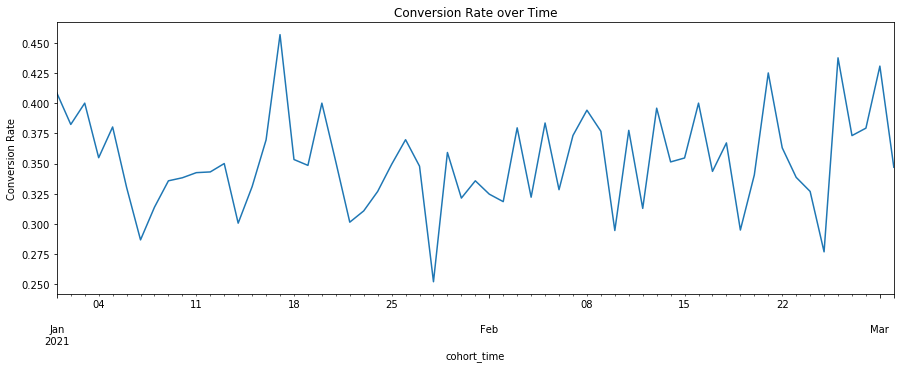

In [3]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
full_data.resample("D", on="cohort_time")["convert"]\
    .apply(lambda x:x.notnull().mean())\
    .plot(ax=ax)

ax.set_ylabel("Conversion Rate")
ax.set_title("Conversion Rate over Time")

One convenient feature of this dataset is that we can see all of the data retrospectively. Notice how the last conversion occurs all the way in May, while the latest cohort date is in march

In [4]:
full_data.convert.max(), full_data.cohort_time.max()

(Timestamp('2021-05-08 01:40:12'), Timestamp('2021-03-02 17:23:02.995094399'))

Thats not very realistic in a business setting, as you'd have data available to you right up until the current day. Let's cut off our dataset as if we were performing an analysis on March 2nd 

When we have entries for users that simply may not have been observed yet, it is known as __censoring__. I.e., for these users we haven't observed a conversion yet

In [5]:
df = full_data[
    
  # only have conversions that occurred before the latest cohort time
 (full_data.convert <= full_data.cohort_time.max()) 
    
  # include users that will never convert (the null entries)
  | (full_data.convert.isnull()) 
    
]

df.head(10)

,cohort_time,convert
user_id,,
0,2021-01-01 00:11:18.782332800,NaT
1,2021-01-01 00:18:06.191078400,2021-01-24 15:04:40
2,2021-01-01 00:35:48.426028800,NaT
3,2021-01-01 00:36:07.866892800,2021-01-14 08:00:58
4,2021-01-01 00:52:52.127097600,NaT
5,2021-01-01 01:01:19.471267200,NaT
6,2021-01-01 01:04:54.427382400,2021-02-14 10:52:27
7,2021-01-01 01:05:23.524137600,NaT
8,2021-01-01 01:52:44.967417599,NaT


Let's plot out what our conversion rate looks like now that there's censoring. Something weird is happening - it looks like the conversion rate is tanking. __This is simply because more recent observations haven't had enough time to convert yet__. Sometimes in industry, this is referred to as `cohort baking`

Text(0.5, 1.0, 'Conversion Rate over Time')

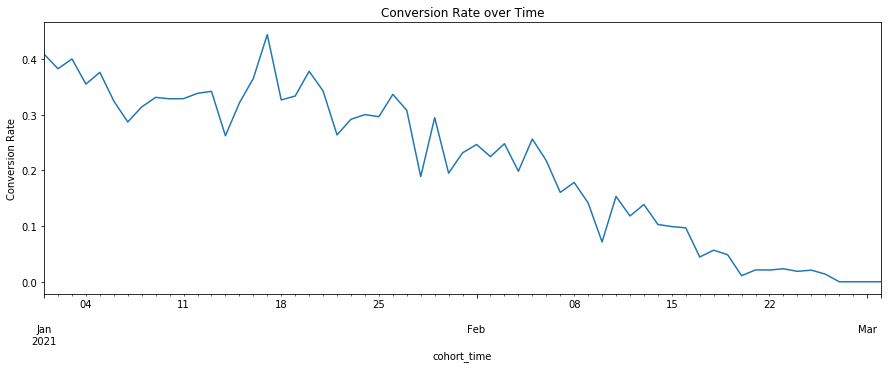

In [6]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
df.resample("D", on="cohort_time")["convert"]\
    .apply(lambda x:x.notnull().mean())\
    .plot(ax=ax)

ax.set_ylabel("Conversion Rate")
ax.set_title("Conversion Rate over Time")

So what's the right way to understand this data? The most common way is to discretize users into cohorts, usually based on the week or the month which they were cohorted.

As a quick sneak peak, we'll plot conversion rate as a function of time since a user was cohorted below

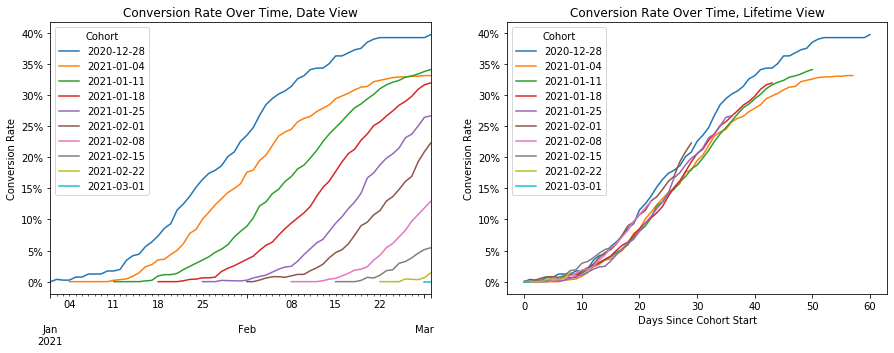

In [7]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

cohort_plot(df, plot_type="date",ax=ax[0])
ax[0].set_title("Conversion Rate Over Time, Date View")
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1,0))

cohort_plot(df, plot_type="lifetime",ax=ax[1])
ax[1].set_title("Conversion Rate Over Time, Lifetime View")
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1,0))



# Simulating Conversion Rate Data
---

Let's simulate conversion data ourselves in order to better understand how this works

### The Binomial Distribution
We'll use the Bernoulli distribution to represent the conversion rate. The binomial distribution has 2 parameters
 * __n__: The number of trials
 * __p__: The success rate

The parameter __p__ is itself commonly modeled with a __beta distribution__, but we wont get into that here

Let's set a conversion rate of $p=0.35$ for 10000 users

In [8]:
n = 10000
p = 0.35
y = np.random.binomial(n=1, p=p ,size=n)
y[:10]

array([1, 1, 1, 0, 0, 1, 0, 0, 0, 1])

By setting n=1, we essentially have a Bernoulli distribution repeated 1000 times, where theres a 35% chance of seeing a 1, which represents success or a conversion.

We can confirm this simply by taking the mean of the array, $y$

In [9]:
y.mean()

0.3496


### The Weibull Distribution
We'll use the Weibull distribution in order to simulate __time to convert__. There are many other commonly used distributions for time to event analysis such as
 * Exponential distribution
 * Generalized Gamma Distribution
 * Gamma Distribution
 * Log-logistic distribution
 

The Weibull distribution has 2 parameters 
 * __k__: shape parameter.
     * When $k < 1$, the event rate decreases over time
     * When $ k = 1$, the event rate is constant over time
     * When $k > 1$, the event rate increases over time
 * $\boldsymbol{\lambda}$: scale parameter, the interpretation is less clear, however its meant to be similar to a rate parameter

Text(0, 0.5, 'CVR')

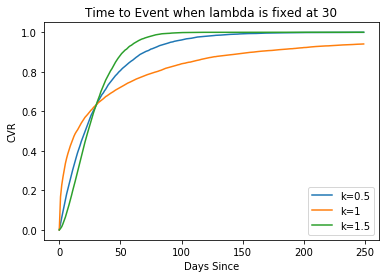

In [10]:
# parameters
lambd = 30
k = 1
t = np.arange(250)

# k=1
events = pm.Weibull.dist(k, lambd).random(size=10000)
plt.plot( (t >= events[:,None]).mean(axis=0), label="k=0.5"  )

# k=0.5
events = pm.Weibull.dist(0.5, lambd).random(size=10000)
plt.plot( (t >= events[:,None]).mean(axis=0), label="k=1"  )

# k=1.5
events = pm.Weibull.dist(1.5, lambd).random(size=10000)
plt.plot( (t >= events[:,None]).mean(axis=0), label="k=1.5" )

plt.legend()
plt.title("Time to Event when lambda is fixed at 30")
plt.xlabel("Days Since")
plt.ylabel("CVR")

Text(0, 0.5, 'CVR')

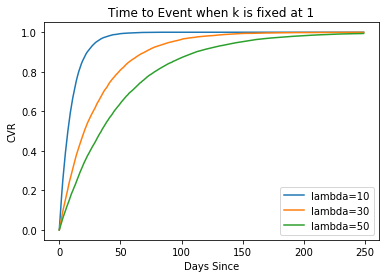

In [11]:
k = 1
t = np.arange(250)

# lambda=10
eventsA = pm.Weibull.dist(k, 10).random(size=10000)
plt.plot( (t >= eventsA[:,None]).mean(axis=0), label="lambda=10"  )

# lambda=30
eventsB = pm.Weibull.dist(k, 30).random(size=10000)
plt.plot( (t >= eventsB[:,None]).mean(axis=0), label="lambda=30"  )

# lambda=50
eventsC = pm.Weibull.dist(k, 50).random(size=10000)
plt.plot( (t >= eventsC[:,None]).mean(axis=0), label="lambda=50" )

plt.legend()
plt.title("Time to Event when k is fixed at 1")
plt.xlabel("Days Since")
plt.ylabel("CVR")

Notice that when k=1, the mean event time is equal to lambda. This isnt the case when k differs from 1 however

In [12]:
eventsA.mean(), eventsB.mean(), eventsC.mean()

(10.019883745676596, 30.140274041282687, 48.97183992780737)

Another key point here - notice how conversion rate when using the Weibull distribution always converges to 1. This is equivalent to assuming that all users eventually convert, which simply is not true. This is why we bring in the binomial distribution to represent conversion rate

## Combining the distributions

We'll start by defining some parameters

In [13]:
# start by defining some parameters
p = 0.5
k = 2.5
lambd = 10

n_users = 10
t = np.arange(20+1)

We'll have an array simulated from a binomial distribution to represent who converted


In [14]:
np.random.seed(99)
convert = np.random.binomial(1,p,size=n_users)
convert

array([1, 0, 1, 0, 1, 1, 0, 0, 1, 0])

We'll have an array simulated from a weibull distribution to represent when people convert (the Weibull distribution assumes everyone converts, so we need to multiply it by the binomial distribution later to relax that assumption)

In [15]:
np.random.seed(99)
time_to_event = pm.Weibull.dist(k, lambd).random(size=n_users)
time_to_event

array([ 6.91118153,  8.7553861 ,  5.16551889, 16.42872598,  5.38838929,
        7.98546793, 10.79918361, 15.65025183,  1.547253  , 19.01681063])

We're going to do some fancy matrix operations here to make things quick.

 * In the matrix below of shape (m,n), each row is a different user (from user 0 to n), while each column is a different time (from time 0 to n)
 * A users entry at time t is 0 if they have not converted yet, and it is 1 if they have converted

In [16]:
arr = (t >= time_to_event[:,None])*1 
arr

array([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

notice that we can calculate the conversion rate at time $t$ simply by taking the mean of each column

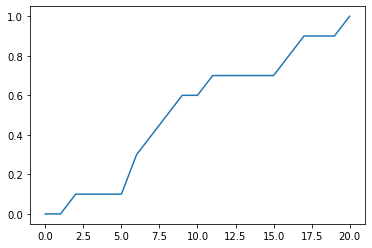

In [17]:
plt.plot( arr.mean(axis=0) )

Now we'll take that array and multiply it by 1 if a user converted and 0 if they did not convert

In [18]:
Ft = arr * convert[:,None]
Ft

array([[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Notice how the conversion rate no longer converges to 1 - instead it converges to the success rate of the binomial distribution

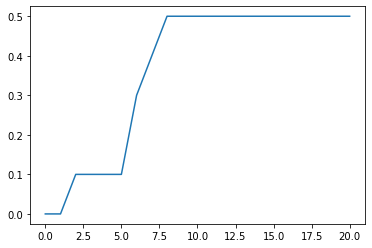

In [19]:
plt.plot( Ft.mean(axis=0) )

Alright, now all we're missing is 1 last piece, the censoring. All we have to do is cut off our data. Lets pretend we only see up until time $t=10$. To do that, anyone who converts later than T>t, we'll set $\text{convert}=0$ and $T=t$

For this one, we're going to re-simulate with more users to make our cohort curves more stable

In [20]:
n_users = 1000
t = np.arange(20+1)

# params
p = 0.5
k = 2.5
lambd = 10

# Simulate
np.random.seed(99)
time_to_event = pm.Weibull.dist(k, lambd).random(size=n_users)
convert = np.random.binomial(1,p,size=n_users)

# Non censored data
df = pd.DataFrame({"B":convert, "T":time_to_event})
df.index.name = "user_id"

# Censored data
df_c = pd.DataFrame({"B":convert, "T":time_to_event})
df_c.index.name = "user_id"

df_c["B"] = np.where(df_c["T"]  > 10, 0, df_c["B"])
df_c["T"] = np.where(df_c["T"]  > 10, 10, df_c["T"] )
df_c.sample(10)

,B,T
user_id,,
931,0,7.839085
838,1,7.595722
547,0,1.816717
424,0,7.640983
448,0,10.000000
109,0,5.403055
52,0,10.000000
903,0,10.000000
856,1,3.372758


Text(0.5, 1.0, 'Cohorted Conversion')

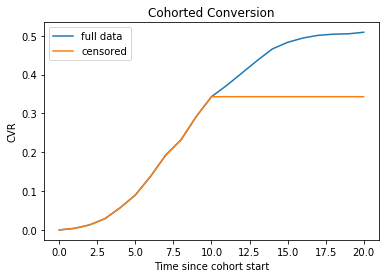

In [21]:
Ft = (t >= df["T"].values[:,None])* df.B.values[:,None]
plt.plot(Ft.mean(axis=0), label="full data")

Ft_c = (t >= df_c["T"].values[:,None])* df_c.B.values[:,None]
plt.plot(Ft_c.mean(axis=0), label="censored")

plt.legend()
plt.ylabel("CVR")
plt.xlabel("Time since cohort start")
plt.title("Cohorted Conversion")

## Full simulation 
The full function (a bit scrappy right now) to simulate data is shown below. Users become cohorted, simulated by a poisson distirbution, and then a weibull and binomial distribution are used to decide if and when users convert

In [22]:
def simulate_conversions(N_per_day, k, lambd, p, days=60, start="2021-01-01 00:00:00", censor=None):
    '''
    N_per_day: The average rate of users per day
    k: The shape parameter of the weibull distribution
    lambd: The scale/rate parameter of the weibull distribution
    p: The Success rate parameter of a bernoulli/binomial distribution
    days: the number of days of data to cohort users
    start: the start datetime of the dataset
    censor: If not none, the dataset is cut off `censor` days after the parameter `days`
    '''
    # Simulate arrivals 
    ## Assumes N_per_day is the rate parameter of a poisson distribution.
    ## A feature of the poisson distribution with parameter lambda is that the time between 
    ## events can be simulated by an exponential distribution with parameter 1/lambda
    arrivals = np.random.exponential(1/N_per_day, size=(N_per_day*60)).cumsum()
    df = pd.DataFrame({
        "start":pd.to_datetime(start), 
        "arrivals":arrivals})
    df["cohort_time"] = df.start + pd.to_timedelta( df.arrivals, unit="d" )
    df.index.name = "user_id" 
    
    # Simulate out time to convert and conversion rate 
    ttc = pm.Weibull.dist(k, lambd).random(size=len(df))
    convert = np.random.binomial(1,p, size=len(df))
    df["convert"] = pd.to_datetime(
        # When users hasnt converted, make convert entry be null
        np.where(convert==1, 
                 df.cohort_time + pd.to_timedelta(ttc, unit="d"),
                 pd.NaT), 
        ).ceil(freq='s') # round nanoseconds to seconds
    
    # if there's no censoring involved, just return the dataframe
    if censor is None:
        return df[["cohort_time", "convert"]]
    
    # if censored, cut-off data
    else:
        end_date = df.cohort_time.max() + timedelta(days=censor)

        df["convert"] = pd.to_datetime(
            np.where(df["convert"] > end_date, pd.NaT, 
                     df["convert"])).ceil(freq='s') 
        
        return df[df.cohort_time <= end_date][["cohort_time", "convert"]]



In [23]:
cohort = simulate_conversions(100, 2.5, 70, 0.25, days=60, censor=40)
cohort.head(15)

,cohort_time,convert
user_id,,
0,2021-01-01 00:19:42.143635200,2021-03-15 01:42:35
1,2021-01-01 00:40:32.576448000,NaT
2,2021-01-01 00:51:22.148668800,NaT
3,2021-01-01 01:01:08.350723200,2021-03-08 09:06:47
4,2021-01-01 01:28:11.477280000,NaT
5,2021-01-01 01:51:03.544531200,2021-03-06 19:40:32
6,2021-01-01 02:04:48.973670400,NaT
7,2021-01-01 02:13:56.002224000,NaT
8,2021-01-01 02:28:42.558585600,NaT


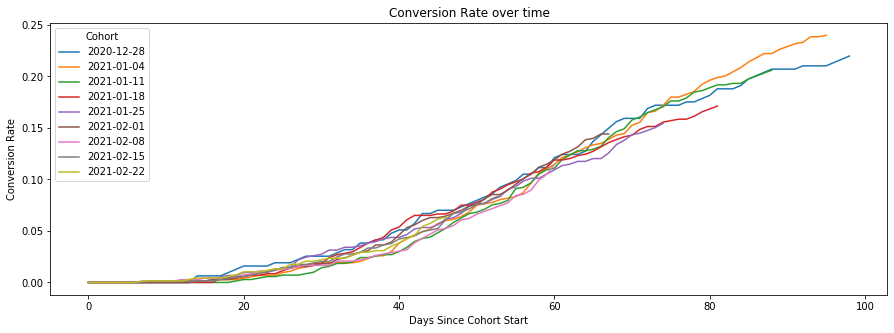

In [24]:
cohort_plot(cohort)

# Modeling Conversion Rate data

---

Modeling conversion rate data is tricky since, the format of the data is simply two datetime columns of cohort start and conversion time.

[Convoys](https://github.com/better/convoys) is a great package to do this out of the box. However there might be times when you need a more custom approach, and knowing how to model it yourself is very useful

Let's start by transforming the data so its ready for modeling. To do this, we'll create 2 vectors, $B$ and $T$, using the same convention as _Convoys_.

In [25]:
cohort = simulate_conversions(N_per_day, 2.5, 40, 0.25, days=60, censor=1)
cohort.head()

,cohort_time,convert
user_id,,
0,2021-01-01 00:06:02.006928000,2021-01-21 02:04:25
1,2021-01-01 01:04:07.772160000,NaT
2,2021-01-01 01:07:40.708416000,NaT
3,2021-01-01 01:21:26.750390400,NaT
4,2021-01-01 01:56:26.762265600,NaT


In [27]:
B = (cohort.convert.notnull()*1).values
analysis_date = cohort.cohort_time.max() + pd.Timedelta(days=1) # 1 day after last cohorted observation
delta = cohort.convert.fillna(analysis_date) - cohort.cohort_time
T = (delta.dt.days + delta.dt.seconds/60/60/24).values

print(B)
print("\n")
print(T)

[1 0 0 ... 0 0 0]


[20.08219907 61.97431713 61.97185185 ...  1.01097222  1.0096412
  1.        ]


Great we now have the format we need. Now let's break out the model. We'll use PyMC3, a bayesian modeling framework. This code snippet below is directly adapted from code from an early github commit on the Convoys package

It's a tricky model for a phew reasons:
 1. We need a custom likelihood function. 
 2. Our observed data is from a joint conversion rate and time to event model
 3. We have censored observations (we're not sure if a user will never convert, or if they just haven't converted yet)
 4. Overflow issues. We calculate everthing on the log-probability scale to prevent these (i.e. numbers too big or numbers too small for a computer to handle properly)
 
Luckily PyMC3 has a `pm.Potential()` function that can allow us to have custom likelihood functions

The likelihood function for this model works as follows

__Step 1: Log Probability of the data given the model__
$$
\text{logp} = B * \text{LL_observed} + (1 - B) * \text{LL_censored}
$$

Remember that B is simply a vector of 1s (converts) and 0s (non-converts). What this line is telling us is that if a user converts (B=1), then the log-likelihood to factor in is `LL_observed`. Otherwise when B=0, and therefore $(1-B)=1$, the log likelihood to factor in and fit on is `LL_censored`

__Step 2: Log-likelood for observed conversions__

The log-likelihood for observed conversions is simple - its just the PDF (probability density function) of the weibull distribtion, multiplied by the probability of conversion. With some algebra, we do this on the log scale and get the following:
$$
\text{LL_observed} = log(c) + log(k) - log(\lambda) + (k-1)(log(T) - log(\lambda)) - (T/\lambda)^k
$$

__Step 3: Log-likelood for censored observations conversions__

The log likelihood for censored observations is a little more complicated. If a user hasn't converted yet, there are two possibilities
 * They could not convert with probability $1-c$
 * The could convert based on the time to event function and the conversion rate $c$

In the former scenario where a user doesnt convert, this is simple, the probability is $(1-C)$. The latter scenario is difficult to understand. The probability of a user not having converted at time $T$ is the survival function, which is the inverse of the CDF (1-CDF), multiplied by the probability of that user converting, $c$. 

$$
\text{LL_censored} = log( (1-c) + c e^{-(T/\lambda)^k} )
$$


In [28]:

with pm.Model() as m:
    
    c = pm.Beta('c', alpha=25, beta=75)  # conversion rate prior
    k = pm.Lognormal('k', mu=0.5, sd=1.0)  # Weak prior for k
    lambd = pm.Exponential('lambd', 0.01)  # Weak prior

    # PDF of Weibull: k / lambda * (x / lambda)^(k-1) * exp(-(t / lambda)^k)
    LL_observed = log(c) + log(k) - log(lambd) + (k-1)*(log(T) - log(lambd)) - (T/lambd)**k
    # CDF of Weibull: 1 - exp(-(t / lambda)^k)
    # (1-C) + C * SF (survival fxn) = C * 1-CDF 
    LL_censored = log((1-c) + c * exp(-(T/lambd)**k))
    
   
    # We need to implement the likelihood using pm.Potential 
    logp = B * LL_observed + (1 - B) * LL_censored
    logpvar = pm.Potential('logpvar', logp.sum())


In [29]:
with m:
    trace = pm.sample(init="advi+adapt_diag", return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 11000
Interrupted at 10,999 [5%]: Average Loss = 7,305.5
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambd, k, c]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


Great the model fit quickly and without any divergences which is a good sign. We'll look at the trace plots below.

On the left column, we see posterior distribution plots, while in the right column we see trace plots - white noise is a good sign that the posterior distribution was explored efficiently, which is exactly what we see

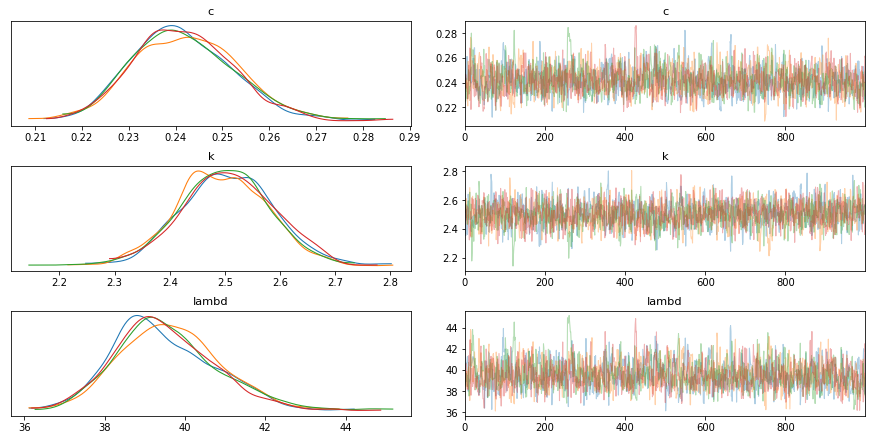

In [30]:
pm.plot_trace(trace);

__Even better, our pre-specified parameters from the `simulate_conversions()` function were properly recovered by the model)__

We can use our posterior distributions to model out the conversion rate at each time T, with uncertainty

In [31]:
cvr_ = trace.posterior["c"].values.reshape(4000,)
lambd_ = (trace.posterior["lambd"]).values.reshape(4000,)
k_ = (trace.posterior["k"]).values.reshape(4000,)

/usr/local/lib/python3.7/site-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


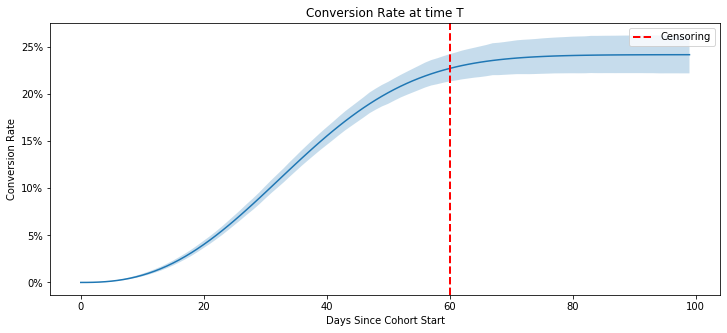

In [32]:
t_ = np.arange(0, 100,1)
Ft = ((1-np.exp(-(t_ / lambd_[:, None])**k_[:, None])) * (cvr_[:,None])).T
ci = az.hdi(Ft.T)

fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(t_, Ft.mean(axis=1));
ax.fill_between(t_, ci[:,0], ci[:,1], alpha=0.25)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,0))
ax.set_ylabel("Conversion Rate")
ax.set_xlabel("Days Since Cohort Start")
ax.set_title("Conversion Rate at time T")
ax.axvline(60, color="r", ls="--", lw=2, label="Censoring")
ax.legend()

The great news is, if we feel comfortable that our assumption of a Weibull distribution was correct, we can extrapolate out what the conversion rate will be later in time. 

We'll overlay the model with the actual data below

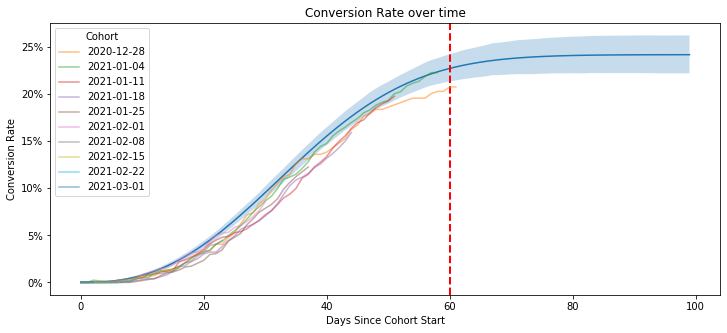

In [33]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
ax.plot(t_, Ft.mean(axis=1));
ax.fill_between(t_, ci[:,0], ci[:,1], alpha=0.25)
ax.axvline(60, color="r", ls="--", lw=2, label="Censoring")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,0))
cohort_plot(cohort,ax=ax, alpha=0.5)


# Extending this to regression modeling
With PyMC3, we can easily regress data onto our rate and conversion parameters. We'll simulate out some data below that is censored at day 100

Text(0.5, 0, 'Time')

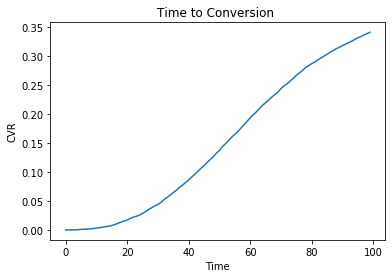

In [34]:
N = 10_000
days = 100
t = np.arange(0, days,1)

# simulate out some covariate X for each user
X = np.random.normal(size=N)[:,None]

# parameters
gamm = 0.1
aT = np.log(70) # 4.24 
b = -0.2
aC = -0.5

# simulate data
lambd_true = np.exp( aT + gamm*X )
T_true = pm.Weibull.dist(2.5, lambd_true).random(size=N) # true time to event (independent of conversion itself)
CVR = logistic( b*X + aC )
# only call it a conversion if they wouldve converted by now AND they convert
p = np.random.binomial(1, CVR)
B = ((T_true < t.max()) & (p.ravel() == 1))*1

# adjust T for non-converts
ttc = (t >= np.where(B==1, T_true, 10000)[:,None]*1)
T = np.where((p.ravel()==0) | (T_true > t.max()), t.max(),T_true)

plt.plot(ttc.mean(axis=0))
plt.title("Time to Conversion ")
plt.ylabel("CVR")
plt.xlabel("Time")


We'll now fit a slightly more complicated model, that regresses lambda and CVR onto X.

`InverseGamma(1,1)` was chosen as a hierarchical regularizing prior on both the $\beta$ and $\gamma$ coefficients, as suggested in the `Convoys` documentation

In [35]:
n, ncoefs = X.shape

with pm.Model() as m2:
    alpha_c = pm.Normal('alpha_c', -5, 1) # intercept for conversion rate
    alpha_lambd = pm.Normal('alpha_lambd', -5, 1) # intercept for conversion rate

    beta_sd = pm.InverseGamma('beta_sd', 1.0,1.0)  # regularizing prior for the regression coefficients
    beta = pm.Normal('beta', mu=0, sd=beta_sd, shape=(ncoefs,))  # Regression coefficients
    gamm = pm.Normal('gamm', mu=0, sd=beta_sd, shape=(ncoefs,))  # Regression coefficients

    c = sigmoid(dot(X, beta) + alpha_c)  # Conversion rates for each example
    lambd = pm.math.exp(dot(X, gamm) + alpha_lambd)
 
    k = pm.Lognormal('k', mu=0.5, sd=1.0)  # Weak prior around k=1

    # PDF of Weibull: k / lambda * (x / lambda)^(k-1) * exp(-(t / lambda)^k)
    LL_observed = log(c) + log(k) - log(lambd) + (k-1)*(log(T) - log(lambd)) - (T/lambd)**k
    # CDF of Weibull: 1 - exp(-(t / lambda)^k)
    # (1-C) + C * SF (survival fxn) = C * 1-CDF 
    LL_censored = log((1-c) + c * exp(-(T/lambd)**k))
   
    # We need to implement the likelihood using pm.Potential
    logp = B * LL_observed + (1 - B) * LL_censored
    logpvar = pm.Potential('logpvar', logp.sum())

In [36]:
with m:
    trace = pm.sample(init="advi+adapt_diag", return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 9800
Interrupted at 9,799 [4%]: Average Loss = 6,299.5
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambd, k, c]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


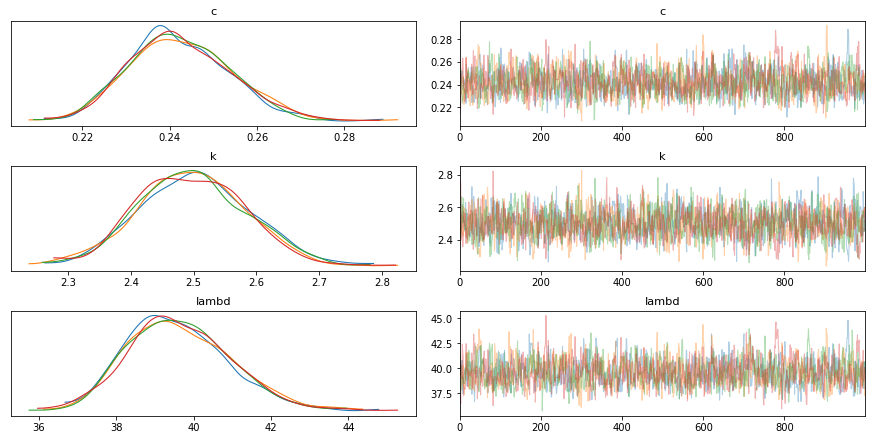

In [37]:
pm.plot_trace(trace);